# Heart Disease Prediction: An Industry-Grade Pipeline
**Objective:** Transform raw medical data into a high-performance predictive model using a robust process-driven approach.

## Pipeline Workflow
We follow a strict 6-stage machine learning process:
1.  **Raw Data**: Ingestion and initial schema validation.
2.  **Data Cleaning**: Handling missing values (Imputation).
3.  **EDA**: Exploratory Data Analysis to understand relationships.
4.  **Feature Encoding**: Converting categorical text to numbers.
5.  **Scaling**: Normalizing numerical features for model stability.
6.  **Model Tuning & Evaluation**: Finding the best parameters and validating prediction quality.

## 1. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from IPython.display import Markdown, display

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

In [2]:
# Plotting config
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme(style="whitegrid")

# Suppress warnings (Fixes 'FutureWarning' noise in graphs)
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [3]:
file_path = r'heart_disease_uci.csv'
df = None
try:
    df = pd.read_csv(file_path)
    display(Markdown(f"**Data Loaded Successfully.** Shape: `{df.shape}`"))
except FileNotFoundError:
    display(Markdown("**Error:** File not found. Please check path."))

**Data Loaded Successfully.** Shape: `(920, 16)`

In [4]:
if df is not None:
    # Standardize column names
    if 'thalch' in df.columns:
        df.rename(columns={'thalch': 'thalach'}, inplace=True)
    
    # Create target column
    if 'num' in df.columns and 'target' not in df.columns:
        df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
        
    # Drop unnecessary columns
    drop_cols = ['id', 'dataset', 'num'] 
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
    
    display(df.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 2. Practical Data Cleaning
*   **Numerical**: Fill gaps with Median.
*   **Categorical**: Fill gaps with Mode.

In [5]:
# Separating Columns by Type
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [6]:
# Imputation Strategy
# Clean numeric columns first to handle any potential strings like '?'
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])

display(Markdown(f"**Missing values clean check:** `{df.isnull().sum().sum()}`"))

**Missing values clean check:** `0`

## 3. Exploratory Data Analysis (EDA)
Visualizing the key risk factors with advanced plots.

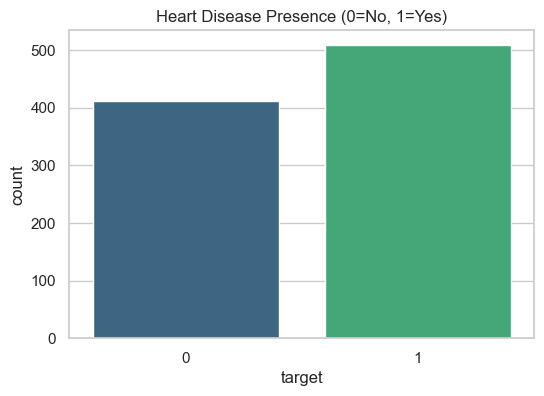

In [7]:
# 1. Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Heart Disease Presence (0=No, 1=Yes)')
plt.show()

### Age & Heart Rate Analysis

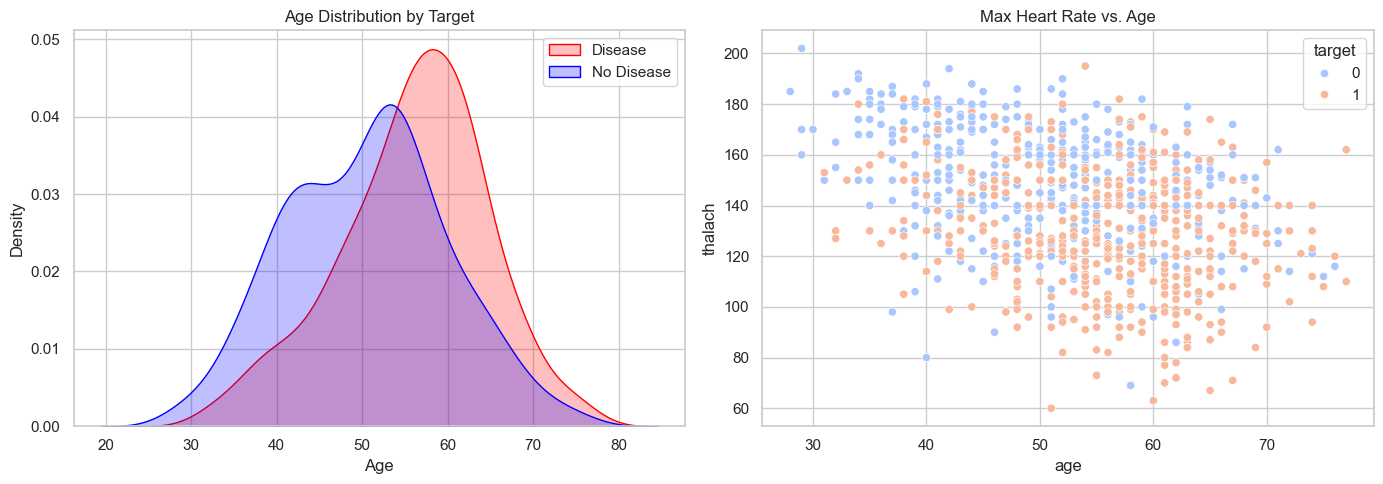

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Age Distribution KDE
sns.kdeplot(df[df['target']==1]['age'], fill=True, color='red', label='Disease', ax=ax[0])
sns.kdeplot(df[df['target']==0]['age'], fill=True, color='blue', label='No Disease', ax=ax[0])
ax[0].set_title('Age Distribution by Target')
ax[0].set_xlabel('Age')
ax[0].legend()

# Heart Rate vs Age Scatter
sns.scatterplot(x='age', y='thalach', hue='target', data=df, palette='coolwarm', ax=ax[1])
ax[1].set_title('Max Heart Rate vs. Age')

plt.tight_layout()
plt.show()

### Chest Pain Type Analysis

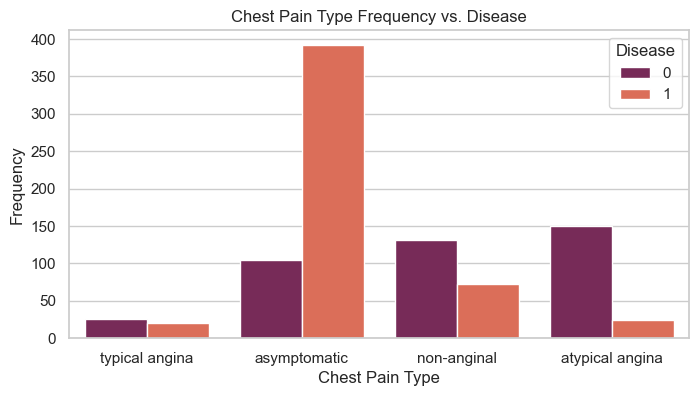

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(x='cp', hue='target', data=df, palette='rocket')
plt.title('Chest Pain Type Frequency vs. Disease')
plt.xlabel('Chest Pain Type')
plt.ylabel('Frequency')
plt.legend(title='Disease', loc='upper right')
plt.show()

### Feature Correlation

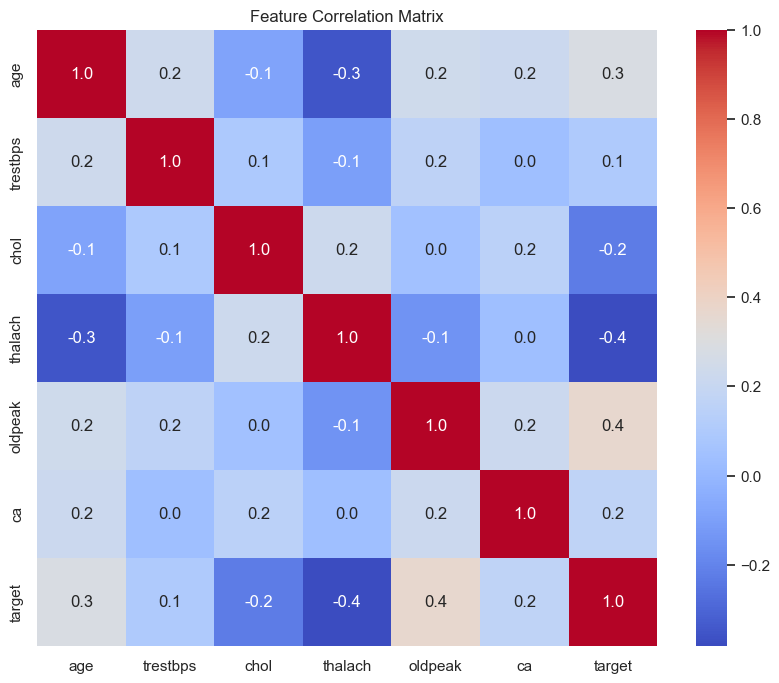

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## 4. Feature Encoding
1.  **Label Encoding**: For binary text variables.
2.  **One-Hot Encoding**: For nominal variables.

In [11]:
# A. Label Encoding (Binary)
binary_cols = ['sex', 'fbs', 'exang', 'target']
for col in binary_cols:
    if col in df.columns:
        if df[col].dtype == 'object':
             df[col] = df[col].map({'Male': 1, 'Female': 0, 'TRUE': 1, 'FALSE': 0, 'True': 1, 'False': 0})
        df[col] = df[col].fillna(0).astype(int)

In [12]:
# B. One-Hot Encoding (Nominal)
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal', 'slope'], drop_first=False) 
display(Markdown(f"**Encoded Data Shape:** `{df_encoded.shape}`"))

**Encoded Data Shape:** `(920, 23)`

## 5. Scaling & Split

In [13]:
# Scaling Numerical Features
scaler = StandardScaler()
features_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
df_final = df_encoded.copy()
df_final[features_to_scale] = scaler.fit_transform(df_final[features_to_scale])

In [14]:
# Train-Test Split (70/30)
X = df_final.drop('target', axis=1)
y = df_final['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(Markdown(f"**Split:** Train `{X_train.shape[0]}` - Test `{X_test.shape[0]}`"))

**Split:** Train `644` - Test `276`

## 6. Baseline Model Evaluation
Testing standard algorithms with default settings.

In [15]:
# Define Models
baseline_models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

In [16]:
# Run Cross-Validation Loop
baseline_scores = []
display(Markdown("**Running Baseline Evaluation (5-Fold CV)...**"))

for name, model in baseline_models.items():
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        baseline_scores.append({"Model": name, "Mean Accuracy": cv_scores.mean()})
    except Exception as e:
        print(f"Failed to evaluate {name}: {e}")

**Running Baseline Evaluation (5-Fold CV)...**

In [17]:
# Show Leaderboard
baseline_df = pd.DataFrame(baseline_scores).sort_values(by="Mean Accuracy", ascending=False)
display(baseline_df)

,Model,Mean Accuracy
7,AdaBoost,0.821512
5,Random Forest,0.816824
0,Logistic Regression,0.815274
2,Support Vector Machine,0.813711
6,Gradient Boosting,0.807510
3,Naive Bayes,0.799721
1,K-Nearest Neighbors,0.788869
4,Decision Tree,0.718968


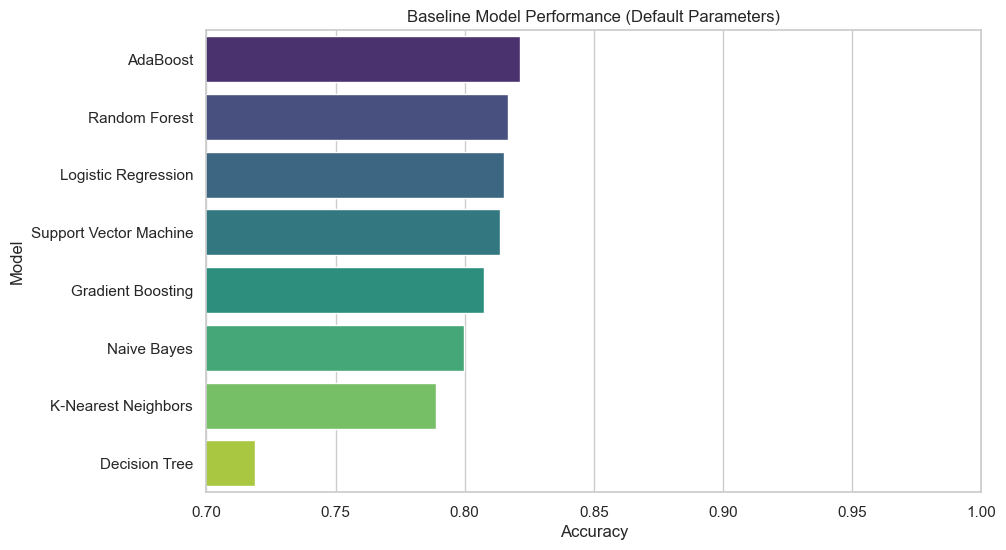

In [18]:
# Visualize Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean Accuracy', y='Model', data=baseline_df, palette='viridis')
plt.title('Baseline Model Performance (Default Parameters)')
plt.xlim(0.7, 1.0)
plt.xlabel('Accuracy')
plt.show()

## 7. Hyperparameter Tuning (The Championship)
Optimizing the models using `GridSearchCV`.

In [19]:
# Define Hyperparameter Grids
champion_params = {
    "Logistic Regression": {
        "model": LogisticRegression(solver='liblinear', max_iter=5000),
        "params": {"C": [0.001, 0.01, 0.1, 1, 5, 10, 25, 50, 100], "penalty": ['l1', 'l2']}
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], "p": [1, 2]}
    },
    "Support Vector Machine": {
        "model": SVC(probability=True),
        "params": {"C": [0.1, 1, 10], "kernel": ['rbf', 'linear']}
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {"var_smoothing": [1e-9, 1e-8, 1e-7]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [None, 5, 10, 20], "min_samples_split": [2, 5, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "max_leaf_nodes": [10, 20, None]}
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5]}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]}
    }
}

In [20]:
# Run GridSearch
tuned_scores = []
best_models = {}

display(Markdown("**Running Championship Tuning (Estimated time: 5-8 mins)...**"))
for model_name, mp in champion_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    best_models[model_name] = clf.best_estimator_
    tuned_scores.append({"Model": model_name, "Best CV Score": clf.best_score_})

**Running Championship Tuning (Estimated time: 5-8 mins)...**

In [21]:
# Display Results
tuned_df = pd.DataFrame(tuned_scores).sort_values(by="Best CV Score", ascending=False)
display(tuned_df)

,Model,Best CV Score
7,AdaBoost,0.826163
5,Random Forest,0.823026
2,Support Vector Machine,0.816836
0,Logistic Regression,0.815274
6,Gradient Boosting,0.812185
1,K-Nearest Neighbors,0.810586
3,Naive Bayes,0.799721
4,Decision Tree,0.760865


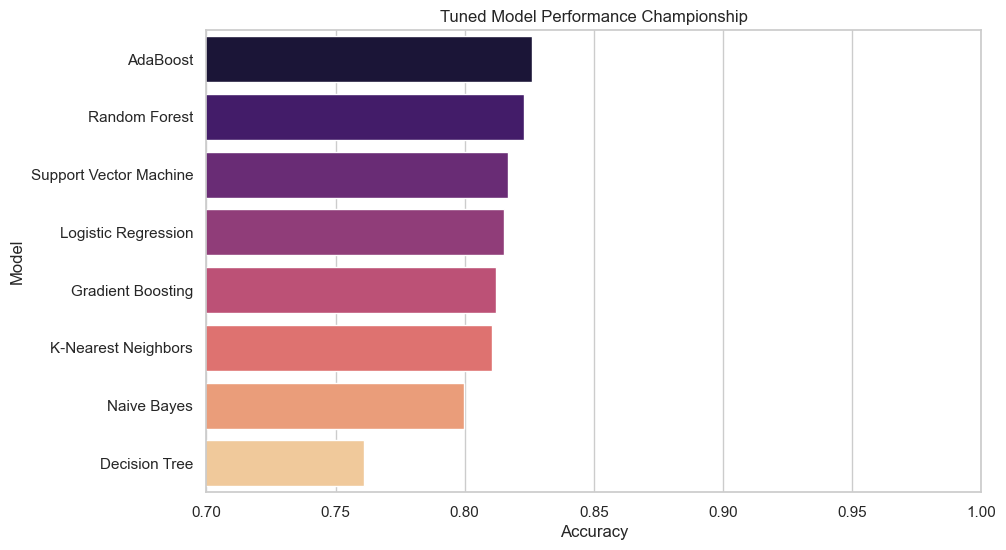

In [22]:
# Visualize Tuned Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Best CV Score', y='Model', data=tuned_df, palette='magma')
plt.title('Tuned Model Performance Championship')
plt.xlim(0.7, 1.0)
plt.xlabel('Accuracy')
plt.show()

## 8. Final Evaluation (The Winner)

In [23]:
# Select Best Model
best_model_name = tuned_df.iloc[0]['Model']
best_clf = best_models[best_model_name]

display(Markdown(f"### 🏆 WINNER: **{best_model_name}** with **{tuned_df.iloc[0]['Best CV Score']:.1%}** Mean CV Accuracy"))

### 🏆 WINNER: **AdaBoost** with **82.6%** Mean CV Accuracy

**Test Set Evaluation:**

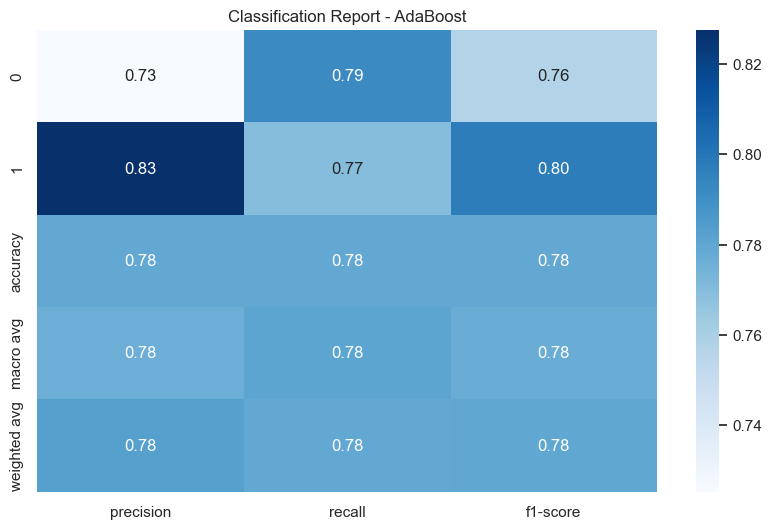

In [24]:
# Predict and Eval
y_pred = best_clf.predict(X_test)
display(Markdown("**Test Set Evaluation:**"))

clf_report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title(f'Classification Report - {best_model_name}')
plt.show()

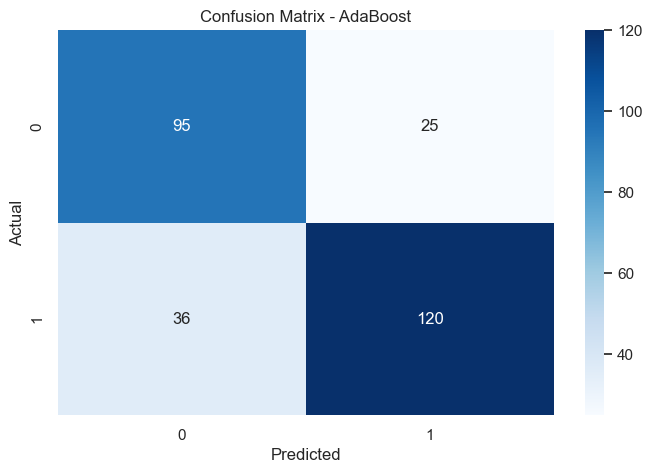

In [25]:
# Confusion Matrix
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 9. Advanced Evaluation Curves

In [26]:
# Calculate Probabilities
if hasattr(best_clf, "predict_proba"):
    y_prob = best_clf.predict_proba(X_test)[:, 1]
else:
    y_prob = best_clf.decision_function(X_test)

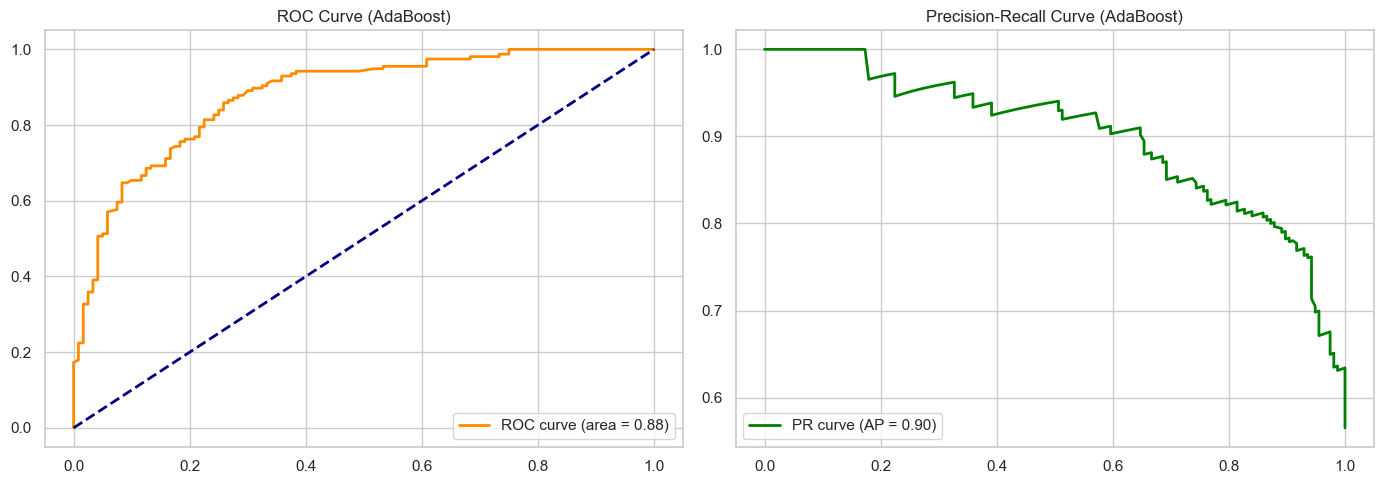

In [27]:
# Plot Curves
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_title(f'ROC Curve ({best_model_name})')
ax[0].legend(loc="lower right")

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)
ax[1].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
ax[1].set_title(f'Precision-Recall Curve ({best_model_name})')
ax[1].legend(loc="lower left")

plt.tight_layout()
plt.show()